# WHL Advanced Power Rankings & Role Assignment

**Ranking Criteria (Power Index 0-100):**
1. **Expected Value (40%):** xGD (Quality of play)
2. **Execution (20%):** Actual GD (Results)
3. **Goaltending (15%):** GSAx (Goals Saved Above Expected)
4. **Puck Management (10%):** Shot Differential
5. **Context (15%):** Pace (Workhorse/Efficiency), Discipline (PIM), OT Resilience

**Roles:**
- Contender, Sleeper, Efficient Workhorse, The Brick Wall, OT Specialist, Most Disciplined, Chaos Factor, Other.

 Rank         team  PowerIndex                       Role   xGD  GD  GSAx  PIM_Game  Pace
    1         peru        78.0                  Contender  29.6  78  36.9       0.6   2.7
    2       brazil        77.8                  Contender  50.7  87  32.8       0.7   2.7
    3     pakistan        77.0                  Contender  51.2  51  21.5       0.8   2.8
    4  netherlands        75.2                  Contender  40.7  69  27.8       0.6   2.6
    5     thailand        72.4                  Contender  73.1  46 -26.3       0.7   2.7
    6           uk        71.6 Most Disciplined Contender  36.3  33  29.0       0.5   2.7
    7        china        69.7                  Contender  34.9  46  28.0       0.6   2.7
    8       panama        65.8                  Contender  16.1  42  28.4       0.6   2.7
    9        india        63.4        Efficient Workhorse   1.4  28  44.9       0.6   2.8
   10       mexico        56.0                    Sleeper  41.2 -17 -30.2       0.7   2.8
   11    g

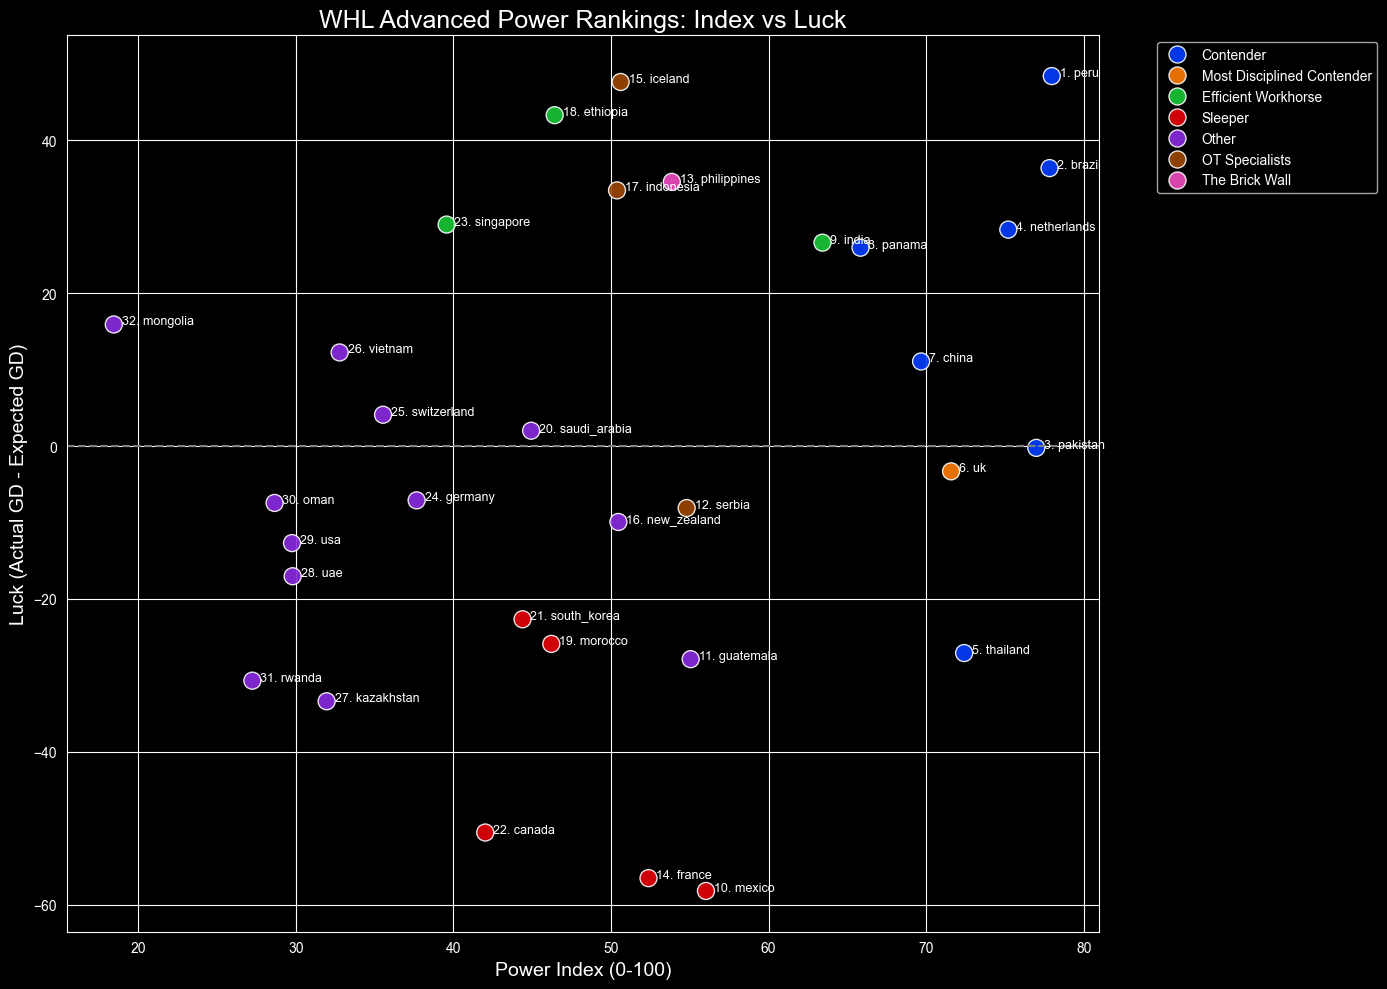

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, rankdata

# Load data
df = pd.read_excel('./datasci/cleanedup/whl_2025_base.xlsx')

# --- Data Processing ---
# Home stats
home_df = df[['game_id', 'home_team', 'home_goals', 'away_goals', 'home_xg', 'away_xg', 'home_shots', 'away_shots', 'home_penalty_minutes', 'went_ot']].copy()
home_df.columns = ['game_id', 'team', 'gf', 'ga', 'xgf', 'xga', 'sf', 'sa', 'pim', 'is_ot']
home_df['is_home'] = 1

# Away stats
away_df = df[['game_id', 'away_team', 'away_goals', 'home_goals', 'away_xg', 'home_xg', 'away_shots', 'home_shots', 'away_penalty_minutes', 'went_ot']].copy()
away_df.columns = ['game_id', 'team', 'gf', 'ga', 'xgf', 'xga', 'sf', 'sa', 'pim', 'is_ot']
away_df['is_home'] = 0

# Combine
team_games = pd.concat([home_df, away_df], ignore_index=True)

# Aggregations
season_stats = team_games.groupby('team').agg(
    gp=('game_id', 'count'),
    gf=('gf', 'sum'),
    ga=('ga', 'sum'),
    xgf=('xgf', 'sum'),
    xga=('xga', 'sum'),
    sf=('sf', 'sum'),
    sa=('sa', 'sum'),
    pim=('pim', 'sum'),
    ot_games=('is_ot', 'sum')
).reset_index()

# --- Feature Engineering ---

# 1. Expected Value & Execution
season_stats['GD'] = season_stats['gf'] - season_stats['ga']
season_stats['xGD'] = season_stats['xgf'] - season_stats['xga']

# 2. Goaltending (GSAx)
# Goals Saved Above Expected = Expected Goals Against - Actual Goals Against
# Positive = Saved more than expected (Good)
season_stats['GSAx'] = season_stats['xga'] - season_stats['ga']

# 3. Puck Management
season_stats['ShotDiff'] = season_stats['sf'] - season_stats['sa']

# 4. Context Metrics
# PIM per Game (Inverse is better for discipline, but we want high PIM for Chaos Factor)
season_stats['PIM_Game'] = season_stats['pim'] / season_stats['gp']

# Pace / Workhorse Proxy (Shots For + Shots Against per game suggests high event/high work)
# Note: User asked for TOI, but without explicit TOI columns in home/away split, Pace is best proxy for "Workload"
season_stats['Pace'] = (season_stats['sf'] + season_stats['sa']) / season_stats['gp']

# --- Normalization (0-100 Scale Prep) ---
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# We normalize inputs to be 0-1 scalled for the index calculation
season_stats['n_xGD'] = normalize(season_stats['xGD'])
season_stats['n_GD'] = normalize(season_stats['GD'])
season_stats['n_GSAx'] = normalize(season_stats['GSAx'])
season_stats['n_ShotDiff'] = normalize(season_stats['ShotDiff'])

# Context Composite:
# Discipline (Low PIM is good for Power Index) -> Invert PIM
season_stats['n_Discipline'] = 1 - normalize(season_stats['PIM_Game'])
# OT Resilience (OT Games * Win%?? Or just OT Games quantity + GD?)
# User said: "OT Resilience (handling pressure)". Let's use OT Games count normalized + GD normalized interaction
season_stats['n_OT_Resilience'] = normalize(season_stats['ot_games']) * 0.5 + normalize(season_stats['GD']) * 0.5
# Efficiency/Stamina (Pace)
season_stats['n_Pace'] = normalize(season_stats['Pace'])

# Context Score (Average of the 3 components)
season_stats['n_Context'] = (season_stats['n_Discipline'] + season_stats['n_OT_Resilience'] + season_stats['n_Pace']) / 3

# --- Power Index Calculation (0-100) ---
season_stats['PowerIndex'] = (
    0.40 * season_stats['n_xGD'] +
    0.20 * season_stats['n_GD'] +
    0.15 * season_stats['n_GSAx'] +
    0.10 * season_stats['n_ShotDiff'] +
    0.15 * season_stats['n_Context']
) * 100

# Ranking
season_stats['Rank'] = season_stats['PowerIndex'].rank(ascending=False).astype(int)
season_stats = season_stats.sort_values('Rank')

# --- Role Assignment Logic ---

# Helper Ranks for Logic
season_stats['xGD_Rank'] = season_stats['xGD'].rank(ascending=False)
season_stats['GD_Rank'] = season_stats['GD'].rank(ascending=False)
season_stats['GSAx_Rank'] = season_stats['GSAx'].rank(ascending=False)
season_stats['PIM_Rank'] = season_stats['PIM_Game'].rank(ascending=False) # Rank 1 = Most Penalties
season_stats['Pace_Rank'] = season_stats['Pace'].rank(ascending=False) # Rank 1 = Highest Pace

def assign_role(row):
    # 1. The Brick Wall: Best GSAx (Rank 1)
    if row['GSAx_Rank'] == 1:
        return 'The Brick Wall'

    # 2. Contenders: Top 8 Power Rank, Good xGD and GD
    if row['Rank'] <= 8:
        return 'Contender'

    # 3. Efficient Workhorse: High Pace (Top 10), Solid Goaltending (Top 16)
    if row['Pace_Rank'] <= 10 and row['GSAx_Rank'] <= 16:
        return 'Efficient Workhorse'

    # 4. Most Disciplined Contender: Top 12 Rank, Low PIM (High PIM Rank, e.g. > 20)
    # Actually "Lowest PIM per game" means PIM_Rank is High number (32).
    # Let's adjust logic: If they are a strong team (Top 12) and very disciplined.
    if row['Rank'] <= 12 and row['PIM_Rank'] >= 20:
        return 'Most Disciplined Contender'

    # 5. Sleepers: Top 15 xGD, but bad GD (>15)
    if row['xGD_Rank'] <= 15 and row['GD_Rank'] > 15:
        return 'Sleeper'

    # 6. Chaos Factor: High PIM (Top 8), Positive xGD
    if row['PIM_Rank'] <= 8 and row['xGD'] > 0:
        return 'Chaos Factor'

    # 7. OT Specialists: High OT count, Positive GD
    if row['ot_games'] >= 2 and row['GD'] > 0:
        return 'OT Specialists'

    # 8. Other
    return 'Other'

# Apply logic - iterate to ensure unique "Brick Wall" etc if needed, but apply function first
season_stats['Role'] = season_stats.apply(assign_role, axis=1)

# Priority Overrides (Ensure best fits)
# Force #1 GSAx to be Brick Wall if not already
brick_wall_team = season_stats.sort_values('GSAx', ascending=False).iloc[0]['team']
season_stats.loc[season_stats['team'] == brick_wall_team, 'Role'] = 'The Brick Wall'

# Force #1 Disciplined (Lowest PIM) in Top 10 to be "Most Disciplined"
top_10 = season_stats[season_stats['Rank'] <= 10]
if not top_10.empty:
    most_disc = top_10.sort_values('PIM_Game', ascending=True).iloc[0]['team']
    season_stats.loc[season_stats['team'] == most_disc, 'Role'] = 'Most Disciplined Contender'

# Output Tables
cols = ['Rank', 'team', 'PowerIndex', 'Role', 'xGD', 'GD', 'GSAx', 'PIM_Game', 'Pace']
print(season_stats[cols].to_string(index=False, float_format='%.1f'))

# --- Visualization ---
plt.style.use('dark_background')
plt.figure(figsize=(14, 10))

# Plotting Power Index vs Luck (GD - xGD)
season_stats['Luck'] = season_stats['GD'] - season_stats['xGD']

sns.scatterplot(
    data=season_stats,
    x='PowerIndex',
    y='Luck',
    hue='Role',
    palette='bright',
    s=150,
    edgecolor='w',
    alpha=0.9
)

# Annotate
for i, row in season_stats.iterrows():
    plt.text(
        row['PowerIndex'] + 0.5,
        row['Luck'],
        f"{row['Rank']}. {row['team']}",
        fontsize=9,
        color='white'
    )

plt.axhline(0, color='gray', linestyle='--')
plt.title('WHL Advanced Power Rankings: Index vs Luck', fontsize=18, color='white')
plt.xlabel('Power Index (0-100)', fontsize=14, color='white')
plt.ylabel('Luck (Actual GD - Expected GD)', fontsize=14, color='white')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()